In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pip install openpyxl
%pip install japanize-matplotlib
%pip install ipympl
%pip install tqdm
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# メモ：
# 一時作業用のノートブックとはいえ、読み込むライブラリをその都度決定するのは面倒臭い
# そのため、将来的に必要になりそうなライブラリを事前にピックアップしておいた
# この部分のみ全ての一時作業に共通のセルとする

import os
import glob
import json
import yaml
import datetime
import requests
import itertools
from typing import Literal, Callable
from pprint import pprint
from pathlib import Path

import multiprocessing as mp
from tqdm.notebook import tqdm

import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

import numpy as np
import pandas as pd
import pyspark as ps
from pyspark import StorageLevel
from pyspark.sql import SparkSession, DataFrame, types
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql.window import Window

from delta.tables import DeltaTable
from delta import configure_spark_with_delta_pip

%matplotlib inline
%matplotlib ipympl

In [4]:
builder = SparkSession.builder\
            .config("spark.sql.sources.commitProtocolClass", "org.apache.spark.sql.execution.datasources.SQLHadoopMapReduceCommitProtocol")\
            .config("mapreduce.fileoutputcommitter.marksuccessfuljobs","false")\
            .config("spark.sql.adaptive.enabled", True)\
            .config("spark.sql.shuffle.partitions", "auto")\
            .config("spark.sql.adaptive.advisoryPartitionSizeInBytes", "100MB")\
            .config("spark.sql.adaptive.coalescePartitions.enabled", True)\
            .config("spark.sql.dynamicPartitionPruning.enabled", True)\
            .config("spark.sql.autoBroadcastJoinThreshold", "10MB")\
            .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")\
            .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")\
            .config("spark.databricks.delta.optimizeWrite.enabled", True)\
            .config("spark.databricks.delta.autoCompact.enabled", True)
            # 出力ファイルのコミット処理を制御するプロトコルを指定
            # '_SUCCESS'で始まるファイルを書き込まないように設定
            # AQE(Adaptive Query Execution)の有効化
            # パーティション数を自動で調整するように設定
            # シャッフル後の1パーティションあたりの最小サイズを指定
            # AQEのパーティション合成の有効化
            # 動的パーティションプルーニングの有効化
            # 小さいテーブルのブロードキャスト結合への自動変換をするための閾値調整
            # Delta Lake固有のSQL構文や解析機能を拡張モジュールとして有効化
            # SparkカタログをDeltaLakeカタログへ変更
            # 書き込み時にデータシャッフルを行い、大きなファイルを生成する機能の有効化
            # 書き込み後に小さなファイルを自動で統合する機能の有効化

spark = configure_spark_with_delta_pip(builder).getOrCreate()


:: loading settings :: url = jar:file:/opt/homebrew/Cellar/apache-spark/4.0.0/libexec/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /Users/h_nagino/.ivy2.5.2/cache
The jars for the packages stored in: /Users/h_nagino/.ivy2.5.2/jars
io.delta#delta-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b8db950f-2050-4d2c-aae8-006403e926fa;1.0
	confs: [default]
	found io.delta#delta-spark_2.13;4.0.0 in central
	found io.delta#delta-storage;4.0.0 in central
	found org.antlr#antlr4-runtime;4.13.1 in central
:: resolution report :: resolve 114ms :: artifacts dl 3ms
	:: modules in use:
	io.delta#delta-spark_2.13;4.0.0 from central in [default]
	io.delta#delta-storage;4.0.0 from central in [default]
	org.antlr#antlr4-runtime;4.13.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       

In [ ]:
def gaussian_kernel(x1:np.array, x2:np.array, param:np.array) -> float:
    """ ガウスカーネルを計算する。
        k(x1, x2) = param[0] exp(-|x - x2|^2/param[1])
    
    Args:
        x1 (np.array)   : 入力値1
        x2 (np.array)   : 入力値2
        param (np.array): ガウスカーネルのパラメータ
    
    Returns:
        float: ガウスカーネルの値
    """

    return param[0] * np.exp(- np.linalg.norm(x1 - x2)**2 / param[1])


def calc_kernel_matrix(x:np.array, kernel:Callable, kparam:np.array) -> np.array:
    """ カーネル行列を計算して返す。
        カーネル行列Kの(i, j)成分はkernel(x[i], x[j])
    
    Args:
        x (np.array)      : 入力値
        kernel (function) : カーネル関数
        kparam (np.array) : カーネル関数のパラメータ
    
    Returns:
        np.array: カーネル行列
    """

    # カーネル行列の初期化
    mkernel = np.zeros((x.shape[0], x.shape[0]))

    for idx_from, idx_to in itertools.product(range(0, len(mkernel)), repeat=2):
        mkernel[idx_from, idx_to] = kernel(x[idx_from], x[idx_to], kparam)
    
    return mkernel


def gp_sampling(x:np.array, λ:float, mean:np.array, kernel:Callable, kparam:np.array) -> np.array:
    """ ガウス過程からサンプルした結果を返す。
    
    Args:
        x (np.array)      : 入力値
        lm (float)        : 共分散行列の定数λ
        mean (np.array)   : ガウス過程の平均ベクトル
        kernel (function) : カーネル関数
        kparam (np.array) : カーネル関数のパラメータ
    
    Returns:
        np.array: サンプルした値
    """

    # カーネル行列の計算
    Φ = calc_kernel_matrix(x, kernel, kparam)

    # 共分散行列の計算
    Σ = λ**2 * np.dot(Φ, Φ.T)
    
    # サンプリング
    return np.random.multivariate_normal(mean, Σ)



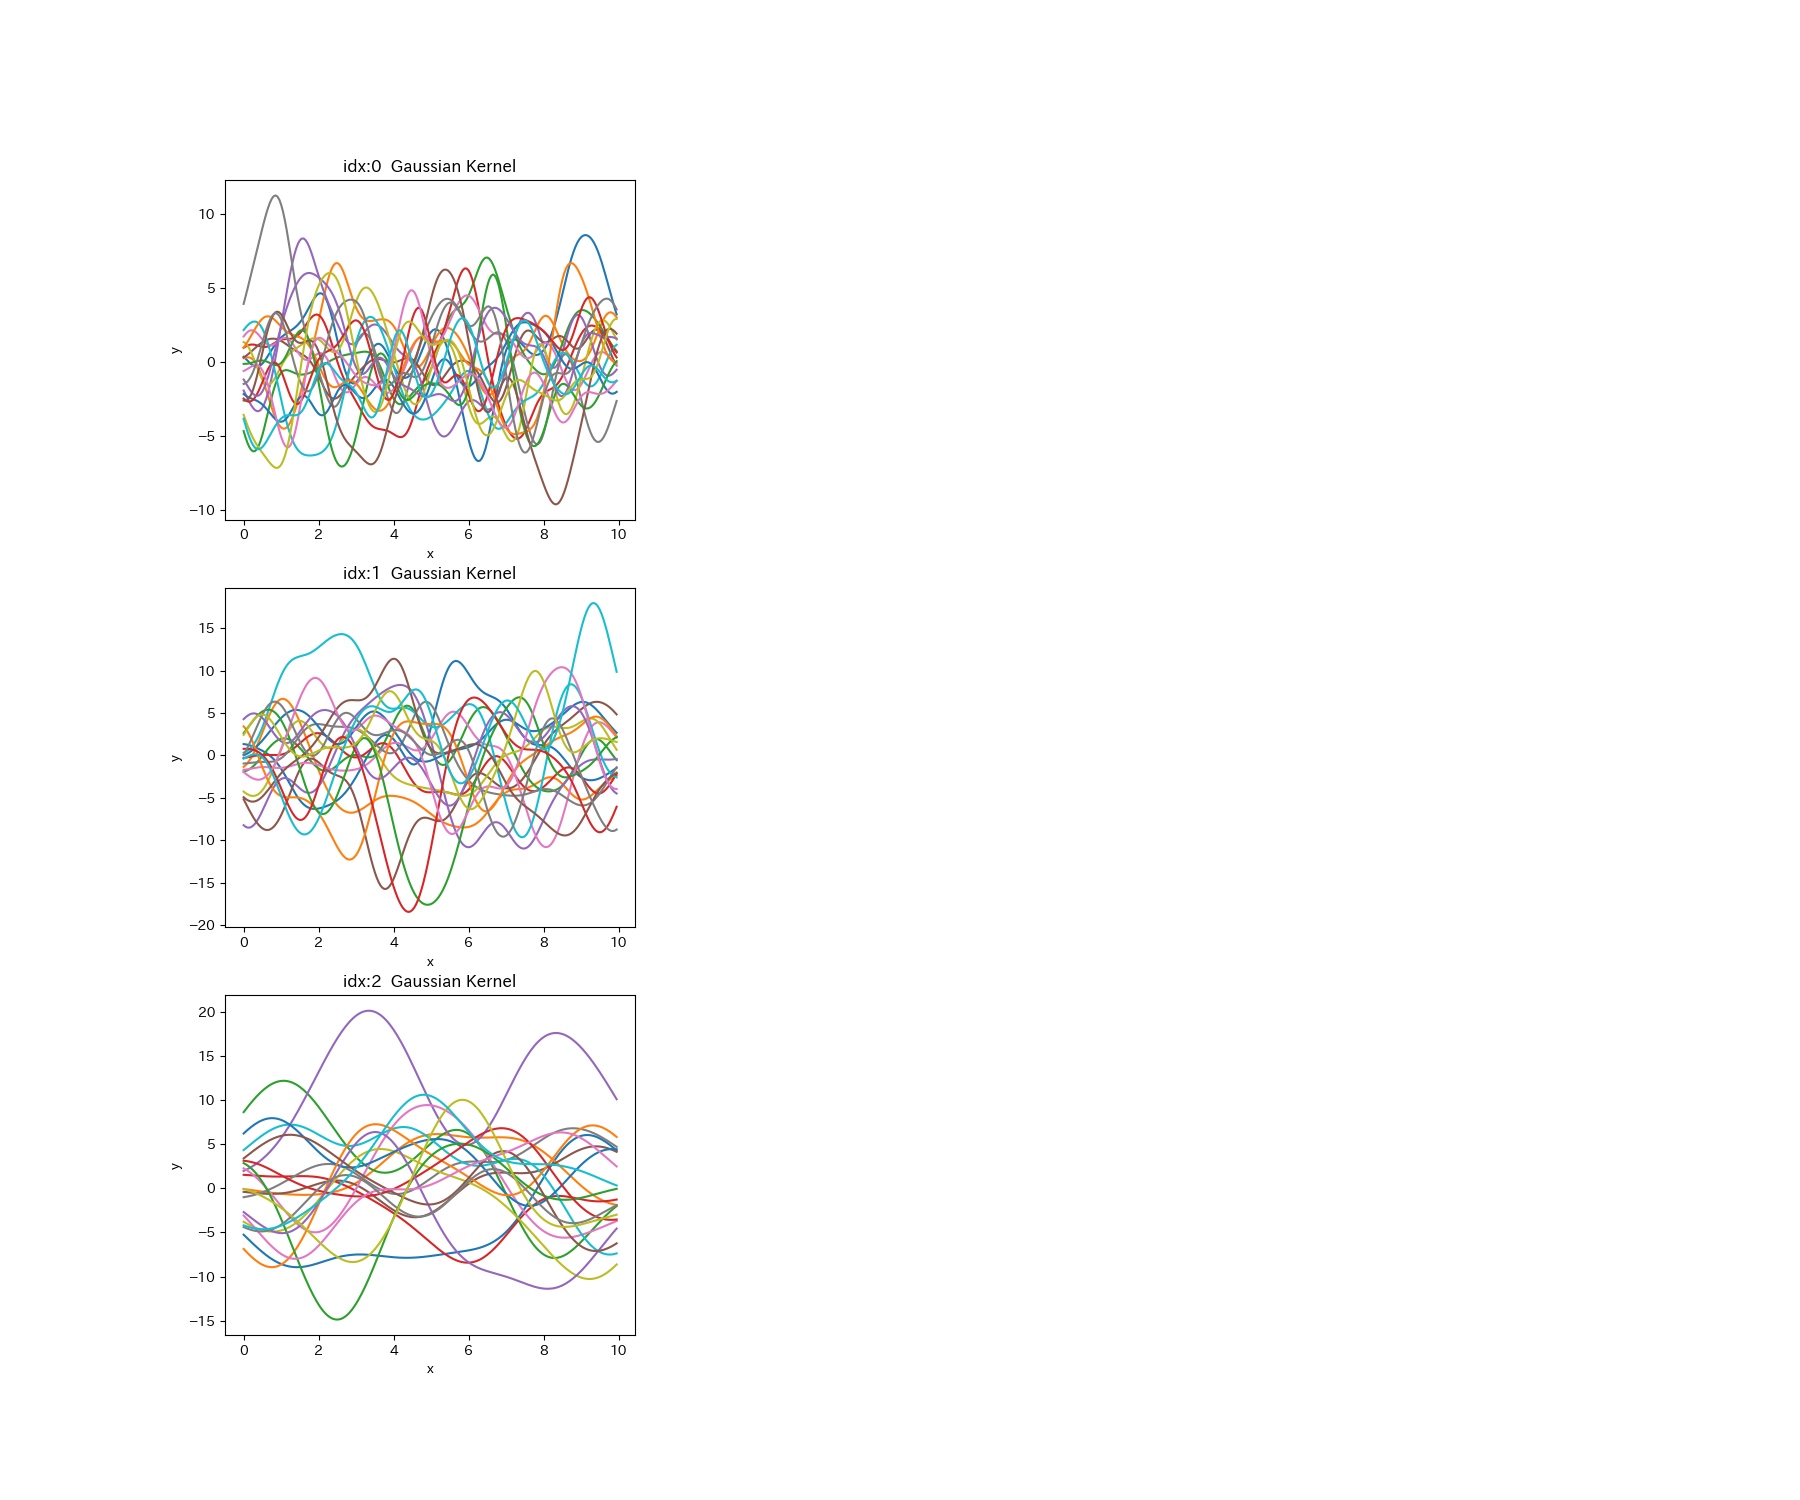

In [6]:
np.random.seed(2)
fig = plt.figure(figsize=(18, 15))

# ガウスカーネル-1次元入力
x           = np.linspace(0, 10, 200, endpoint=False)
kparam_list = [np.array([0.8, 0.25]), np.array([1.2, 0.5]), np.array([1.0, 2.5])]
y_list      = []
for kparam in kparam_list: # サンプリング
	y_list.append(np.array([gp_sampling(x, 1.0, np.zeros(len(x)), gaussian_kernel, kparam) for _ in range(20)]))

for i_plot, ys in enumerate(y_list): # 作図
	ax = fig.add_subplot(3, 3, 3*i_plot + 1)
	for y in ys:
		ax.plot(x, y)
	ax.set_xlabel('x')
	ax.set_ylabel('y')
	ax.set_title(f'idx:{i_plot}  Gaussian Kernel')

